In [1]:
import nltk
import spacy
nlp = spacy.load('en_core_web_md')
import pandas as pd
import re
import warnings
import string
from nltk.corpus import stopwords

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", message=r"\[W008\]", category=UserWarning)

2022-12-02 17:13:46.753549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 17:13:47.147563: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-02 17:13:48.224566: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-02 17:13:48.224663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

#### Read from csv file to Pandas Dataframe

In [2]:
df = pd.read_csv('QAs.txt',usecols=[0,1], names=['ans_index', 'answer'], header=None, sep='\t')
df.head()

,ans_index,answer
0,1,Abstraction is generalizing concepts. Engineer...
1,2,İnvested Zero. and then invested number. First...
2,3,there is a famous line : today's abstract mat...
3,4,Abstraction is one of the greatest tool of the...
4,5,Before abstract Math is today's proven science...


#### extract whitespace answers and Null answers also remove dup[licate same answers] for DATA Cleaning

In [3]:
def cleaning_data(df: pd.DataFrame()):
    df_c = df.copy()
    df_c.dropna(inplace=True)
    blanks = []

    for i, ans_ind, answers in df_c.itertuples():  
        if type(answers)==str:            
            if answers.isspace():         
                blanks.append(i)    

    df_c.drop(blanks, inplace=True)
    df_c['answer'] = df_c['answer'].str.lower()
    df_c = df_c.apply(lambda x: x.astype(str).str.lower()).drop_duplicates(keep='first')
    df_c = df_c.reset_index(drop=True)
    return df_c
    

In [4]:
df = cleaning_data(df)
df.tail()

,ans_index,answer
128,138,we can abstract some physical things to mathem...
129,139,helps engineers foresee the problems and makes...
130,140,when we abstract something before we work on i...
131,141,they can think correctly of calculations . ab...
132,142,we can imagine the problem in our head by abst...


#### add sent numbers column for detect graduat or undergraduate

In [5]:
def add_sent_numbers(df_temp: pd.DataFrame()):
    df_temp['sent_numbers'] = 0
    for i, ans_ind, answers, sent_no in df_temp.itertuples():  
        doc_temp = nlp(answers)
        k = 0
        for j in doc_temp.sents:
            k += 1
        df_temp.at[i, 'sent_numbers'] = k

<AxesSubplot: >

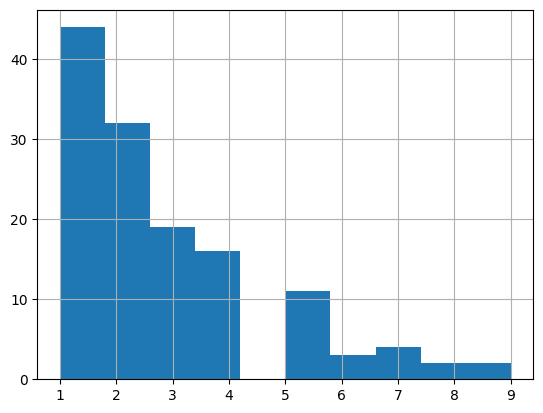

In [6]:
add_sent_numbers(df)
df.sent_numbers.hist()

In [7]:
# Autocorrect for spelling
from textblob import TextBlob

def uncommon_words(A, B):
    count = {}
    for word in A.split():
        count[word] = count.get(word, 0) + 1
    for word in B.split():
        count[word] = count.get(word, 0) + 1
    return [word for word in count if count[word] == 1]

spelling_words = []
for i in df.index:
    cleaning_answer = re.findall("[a-zA-Z,.]+",df.answer[i])
    updated_ans = (" ".join(cleaning_answer))
    temp_ans = str(TextBlob(updated_ans).correct())
    spelling_words += uncommon_words(temp_ans, df.answer[i])
    df.answer[i] = temp_ans

/tmp/ipykernel_419/3298711748.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.answer[i] = temp_ans


In [8]:
def Tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [9]:
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = tf.cast(tf.tile(tf.expand_dims(attention_mask, -1), [1, 1, token_embeddings.shape[-1]]), tf.float32)
    return tf.math.reduce_sum(token_embeddings * input_mask_expanded, 1) / tf.math.maximum(tf.math.reduce_sum(input_mask_expanded, 1), 1e-9)

def encode(texts, tokenizer, model):
    
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='tf')
    model_output = model(**encoded_input, return_dict=True)

    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    embeddings = tf.math.l2_normalize(embeddings, axis=1)

    return embeddings

In [10]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1")
model = TFAutoModel.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1")

2022-12-02 17:14:08.632208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 17:14:08.633821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-02 17:14:08.633913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-02 17:14:08.633949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

In [11]:
query = "How does the abstraction helps engineering ?"

In [12]:
df['get_multiqa_score'] = 0
for index, ans_ind, ans, sent, *scr in df.itertuples():
    query_emb = encode(query, tokenizer, model)
    doc_emb = encode([df.answer[index]], tokenizer, model)

#Compute dot score between query and all document embeddings
    scores = (query_emb @ tf.transpose(doc_emb))[0].numpy().tolist()

#Combine docs & scores
    doc_score_pairs = list(zip([df.answer[index]], scores))

#Sort by decreasing score
    doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)

#Output passages & scores
    for doc, score in doc_score_pairs:
        df.loc[index, 'get_multiqa_score'] = score
        print(score, doc)

0.8035311698913574 abstraction is generalizing concepts. engineers can use this for calculating abstract things. this helps for engineers to solving abstract problems. abstraction is useful for think easily
0.19511213898658752 i vested zero. and then invested number. first of all binary system. then we calculate some science and path problems with this invested.
0.3993949294090271 there is a famous line today s abstract path is tomorrow s applied. which means that we developed path .and better way to express things with abstract path.
0.7812587022781372 abstraction is one of the greatest tool of the engineer. by abstraction a problem we can solve little pieces of a bigger problem and connect all of the at the end.
0.4578796625137329 before abstract path is today s prove science. some ideas can be abstract now, however it might be prove by other scientists in the future. so it is important to get a development.
0.45490309596061707 with abstraction we can understand things that difficult

<AxesSubplot: title={'center': 'multi-qa-MiniLM-L6-cos-v1 Solutions'}, xlabel='ans_index', ylabel='get_multiqa_score'>

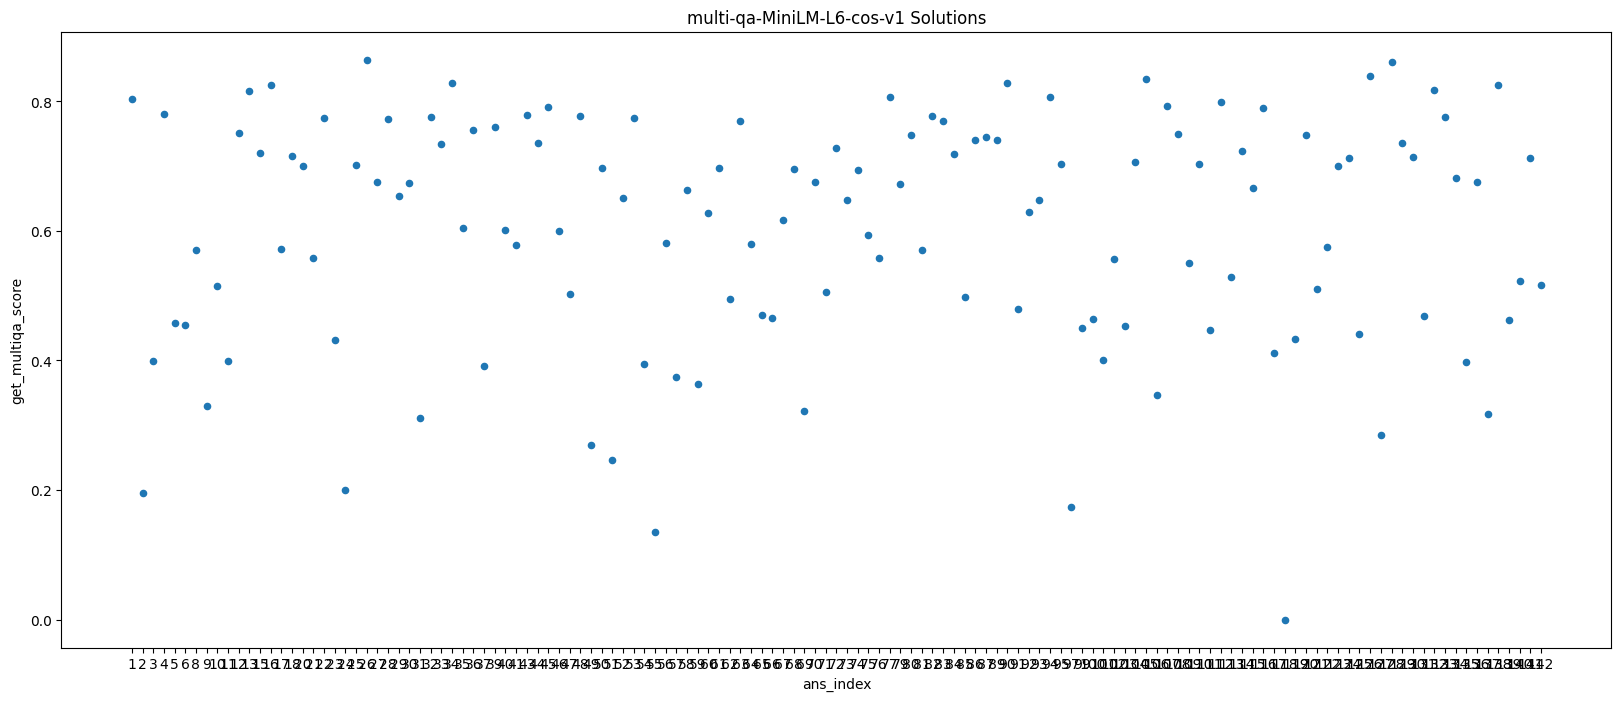

In [13]:
df.plot.scatter(x='ans_index', y='get_multiqa_score', title='multi-qa-MiniLM-L6-cos-v1 Solutions', figsize=(20,8))

We’ll use levenshtein distance, Hamming distance, Needleman-Wunsch
— While having conversation with chatbots type/spell error happens and therefore context understanding becomes difficult, this is where spell correction can come handy

— OCR post-processing — Till now no ocr gives 100% accurate results, there is always some misspell happens.

— Fuzzy search & approximate string matching is another field where spell check/correction can be used. and there are many more applications.

Jamspell pip install jamspell is a modern spellchecking library. It is light-weight, fast and accurate. It consider word surroundings to make better corrections. It has following features:
It considers words surroundings (context) for better correction
Nearly 5K words per second
Multi-language →it’s written in C++ and available for many languages with swig bindings
Symspellpy pip install symspellpyThe Symmetric Delete spelling correction algorithm reduces the complexity of edit candidate generation and dictionary lookup for a given Damerau-Levenshtein distance. It is six orders of magnitude faster (than the standard approach with deletes + transposes + replaces + inserts) and language independent. An average 5 letter word has about 3 million possible spelling errors within a maximum edit distance of 3, but SymSpell needs to generate only 25 deletes to cover them all, both at pre-calculation and at lookup time.
Textblob pip install textblob textblob’s spelling correction is based on Peter Norvig’s “How to Write a Spelling Corrector” as implemented in the pattern library.

Levenshtein Distance
There are many ways to identify the lexical similarities between a pair of texts, the one which we’ll be covering today is Levenshtein distance. An algorithm invented in 1965 by Vladimir Levenshtein, a Soviet mathematician

In [14]:
from transformers import DistilBertTokenizer, TFDistilBertForQuestionAnswering, pipeline
import tensorflow as tf

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-cased-distilled-squad")
model = TFDistilBertForQuestionAnswering.from_pretrained("distilbert-base-cased-distilled-squad")

score_list = []
for index, ans_ind, ans, sent, *scr in df.itertuples():
    question, text = "How does the abstraction helps engineering ?", df.answer[index]

    question_answerer = pipeline("question-answering", model = model, tokenizer= tokenizer)

    result = question_answerer(question=question, context = text)
    score_list.append(
        result
    )

Some layers from the model checkpoint at distilbert-base-cased-distilled-squad were not used when initializing TFDistilBertForQuestionAnswering: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased-distilled-squad and are newly initialized: ['dropout_38']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
df_test = pd.DataFrame(score_list)

In [16]:
df["score_label"] = df_test['score']
df.head()

,ans_index,answer,sent_numbers,get_multiqa_score,score_label
0,1,abstraction is generalizing concepts. engineer...,4,0.803531,0.155826
1,2,i vested zero. and then invested number. first...,4,0.195112,0.111170
2,3,there is a famous line today s abstract path i...,2,0.399395,0.387697
3,4,abstraction is one of the greatest tool of the...,2,0.781259,0.301812
4,5,before abstract path is today s prove science....,3,0.457880,0.175937


<AxesSubplot: title={'center': 'distilbert-base-cased-distilled-squad Solutions'}, xlabel='ans_index', ylabel='score_label'>

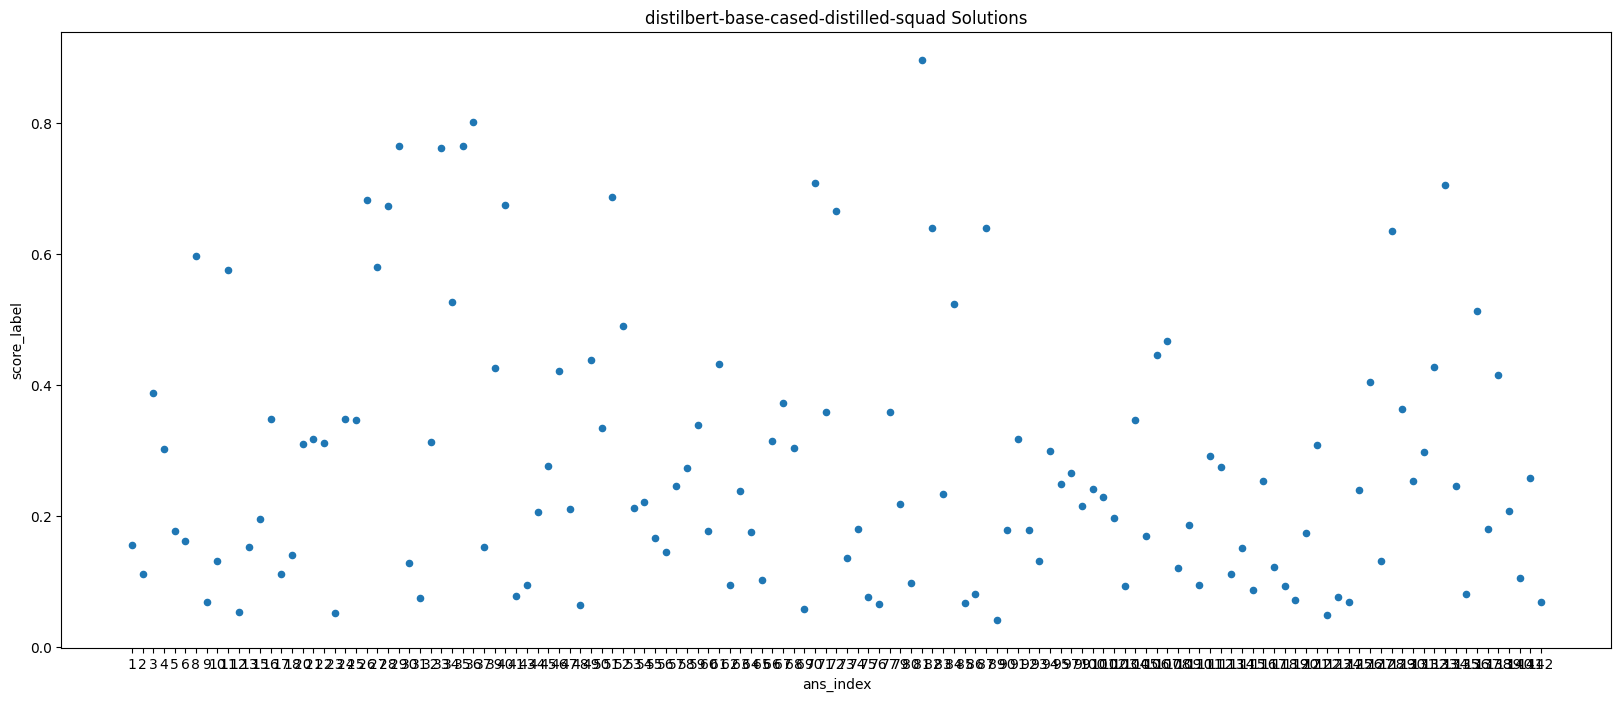

In [17]:
df.plot.scatter(x='ans_index', y='score_label', title='distilbert-base-cased-distilled-squad Solutions', figsize=(20,8))

In [18]:
mean_score = df['score_label'].mean()

In [19]:
df['status'] = (df['score_label'] > mean_score).astype(int)
df.head()

,ans_index,answer,sent_numbers,get_multiqa_score,score_label,status
0,1,abstraction is generalizing concepts. engineer...,4,0.803531,0.155826,0
1,2,i vested zero. and then invested number. first...,4,0.195112,0.111170,0
2,3,there is a famous line today s abstract path i...,2,0.399395,0.387697,1
3,4,abstraction is one of the greatest tool of the...,2,0.781259,0.301812,1
4,5,before abstract path is today s prove science....,3,0.457880,0.175937,0


In [20]:
df.status.value_counts()

0    79
1    54
Name: status, dtype: int64

In [21]:
from sklearn.model_selection import train_test_split

X = df['answer']
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

text_clf.fit(X_train, y_train) 

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [23]:
predictions = text_clf.predict(X_test)
from sklearn import metrics
print(f'Condusion Matrix for xgb')
print(metrics.confusion_matrix(y_test,predictions))
print(metrics.classification_report(y_test,predictions))
print(metrics.accuracy_score(y_test,predictions))

Condusion Matrix for xgb
[[14  3]
 [ 7  3]]
              precision    recall  f1-score   support

           0       0.67      0.82      0.74        17
           1       0.50      0.30      0.37        10

    accuracy                           0.63        27
   macro avg       0.58      0.56      0.56        27
weighted avg       0.60      0.63      0.60        27

0.6296296296296297


In [24]:
from xgboost import XGBClassifier

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', XGBClassifier()),
])
text_clf.fit(X_train, y_train) 

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

In [25]:
predictions = text_clf.predict(X_test)
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))
print(metrics.classification_report(y_test,predictions))
print(metrics.accuracy_score(y_test,predictions))

[[9 8]
 [3 7]]
              precision    recall  f1-score   support

           0       0.75      0.53      0.62        17
           1       0.47      0.70      0.56        10

    accuracy                           0.59        27
   macro avg       0.61      0.61      0.59        27
weighted avg       0.65      0.59      0.60        27

0.5925925925925926


In [26]:
def extract_answer_from_complete_text(df_t: pd.DataFrame()):
    answer_text = ' '.join(df_t.answer.to_list())
    qa_model = pipeline("question-answering", model='distilbert-base-cased-distilled-squad')
    question = "How does the abstraction helps engineering ?"
    context = answer_text
    result = qa_model(question=question, context=context)
    correct_answer_index = int(str(df_t.loc[df_t['answer'].str.contains(result['answer']), 'answer'])[:3])
    correct_answer_sentences = df_t.loc[correct_answer_index, 'answer']
    return correct_answer_sentences


answer_text = ' '.join(df.answer.to_list())
qa_model = pipeline("question-answering", model='distilbert-base-cased-distilled-squad')
question = "How does the abstraction helps engineering ?"
context = answer_text
result = qa_model(question=question, context=context)
p = df.loc[df['answer'].str.contains(result['answer']), 'answer']

Some layers from the model checkpoint at distilbert-base-cased-distilled-squad were not used when initializing TFDistilBertForQuestionAnswering: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased-distilled-squad and are newly initialized: ['dropout_58']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
correct_answer_index = int(str(df.loc[df['answer'].str.contains(result['answer']), 'answer'])[:3])

In [28]:
correct_answer_sentences = df.loc[correct_answer_index, 'answer']
print(f'Correct Answer From compound Answer Text is: \n\"{correct_answer_sentences}\"')

Correct Answer From compound Answer Text is: 
"it is modeling the structures and that helps to engineer. engineer solved problems and thinks better with abstraction."


In [29]:
import numpy as np
def get_similarities_correct_answers(answer: str, df_t: pd.DataFrame()):
    df_t['similarity_to_true'] = np.nan
    for i in df_t.index:
        res = nlp(answer).similarity(nlp(df_t.answer[i]))
        df_t.at[i, 'similarity_to_true'] = res

In [30]:
query = "Abstraction, or the process of generalizing ideas by understanding examples, is an indispensable tool in the engineering proces"

In [31]:
get_similarities_correct_answers(query, df)

<AxesSubplot: title={'center': 'similarity with spacy for User-Provided answer'}, xlabel='ans_index', ylabel='similarity_to_true'>

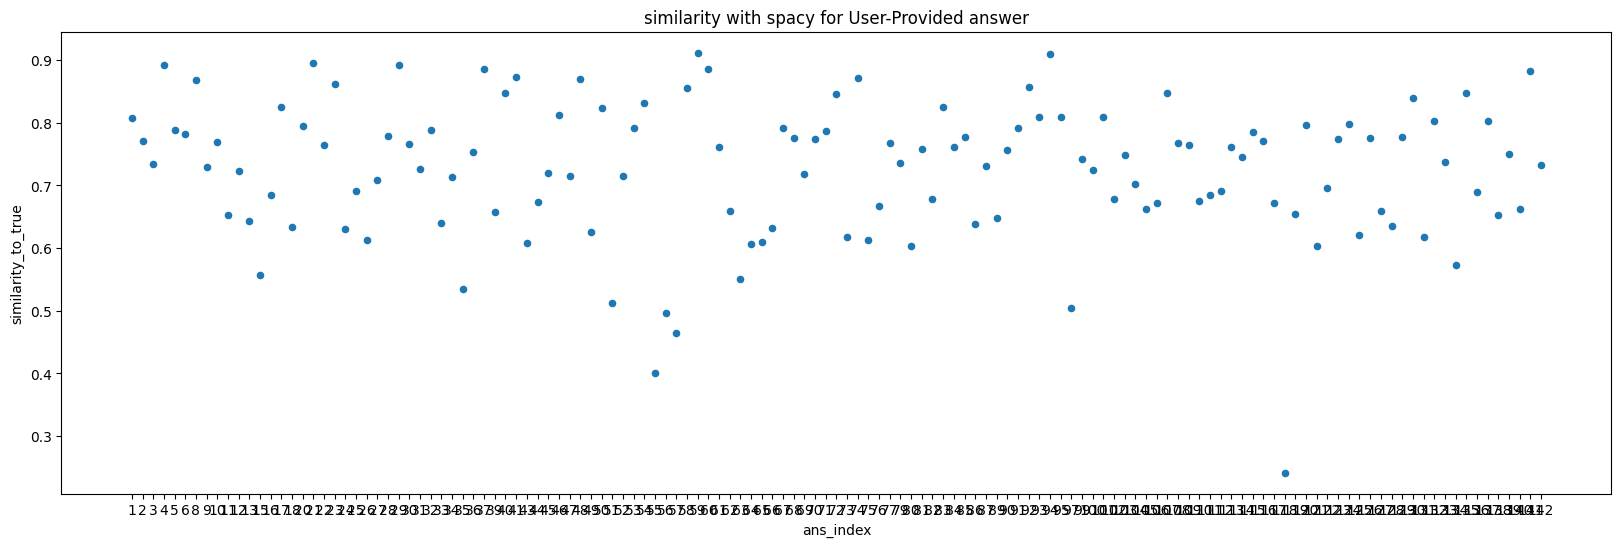

In [36]:
df.plot.scatter(x='ans_index', y='similarity_to_true', title='similarity with spacy for User-Provided answer', figsize=(20,6))

<AxesSubplot: title={'center': 'Mean value for all results'}, xlabel='ans_index', ylabel='get_mean_all_results'>

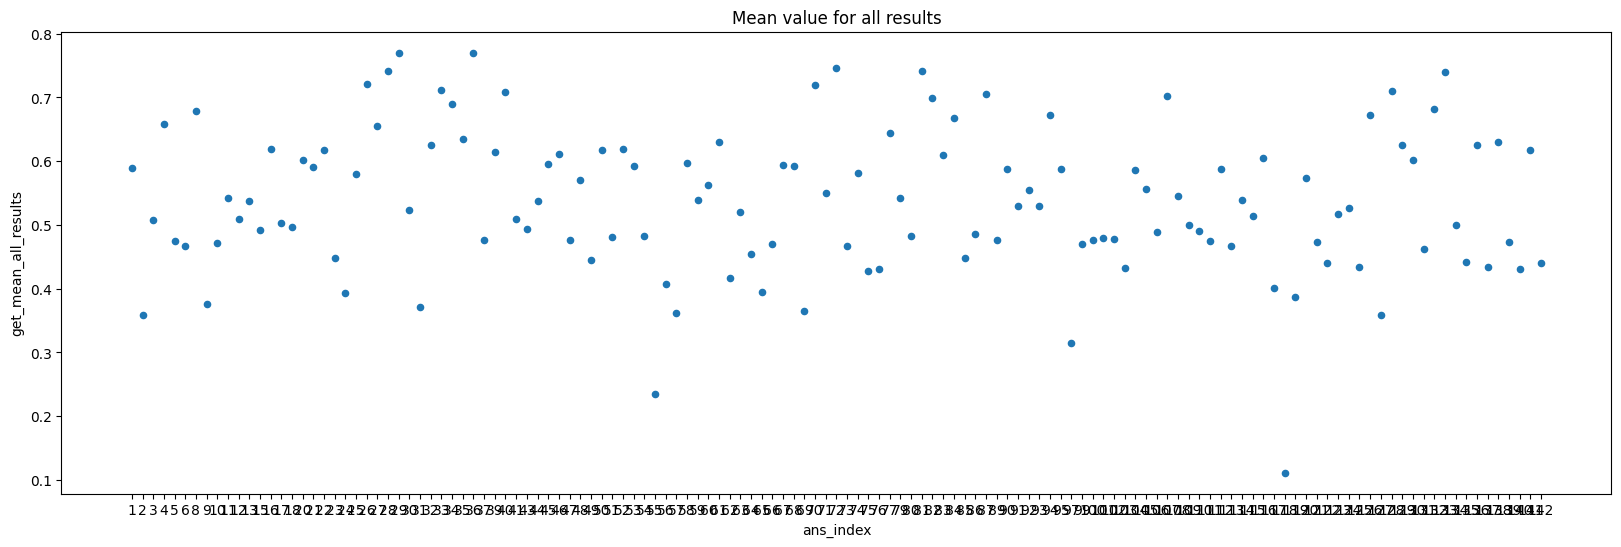

In [37]:
df['get_mean_all_results'] = (df['similarity_to_true'] + df['score_label'] + df['get_multiqa_score'])/3
df.plot.scatter(x='ans_index', y='get_mean_all_results', title='Mean value for all results', figsize=(20,6))

<AxesSubplot: >

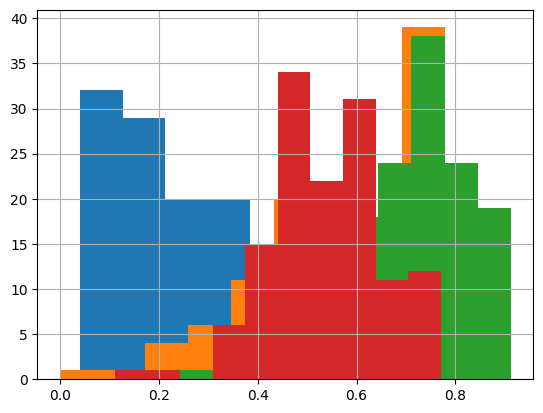

In [38]:
df.score_label.hist()
df.get_multiqa_score.hist()
df.similarity_to_true.hist()
df.get_mean_all_results.hist()

In [46]:
for i in df.index:
    print(f'{df["ans_index"][i]:3}. answer, score: {int(df["get_mean_all_results"][i]*100)}')    

1  . answer, score: 58
2  . answer, score: 35
3  . answer, score: 50
4  . answer, score: 65
5  . answer, score: 47
6  . answer, score: 46
8  . answer, score: 67
9  . answer, score: 37
10 . answer, score: 47
11 . answer, score: 54
12 . answer, score: 50
13 . answer, score: 53
15 . answer, score: 49
16 . answer, score: 61
17 . answer, score: 50
18 . answer, score: 49
20 . answer, score: 60
21 . answer, score: 59
22 . answer, score: 61
23 . answer, score: 44
24 . answer, score: 39
25 . answer, score: 58
26 . answer, score: 72
27 . answer, score: 65
28 . answer, score: 74
29 . answer, score: 76
30 . answer, score: 52
31 . answer, score: 37
32 . answer, score: 62
33 . answer, score: 71
34 . answer, score: 68
35 . answer, score: 63
36 . answer, score: 77
37 . answer, score: 47
39 . answer, score: 61
40 . answer, score: 70
41 . answer, score: 50
43 . answer, score: 49
44 . answer, score: 53
45 . answer, score: 59
46 . answer, score: 61
47 . answer, score: 47
48 . answer, score: 57
49 . answer